# Milestone 4 - Visualising Filter Maximizations, Grad-CAM and Class Maximization

__Objective__: 
- Visualize filter maximizations of a pretrained CNN. The purpose is to get experience in performing gradient ascent and utilizing Keras’s backend functions.
- Visualize what areas in an image activate a CNN’s decision-making process using Gradient-weighted Class Activation Mapping (Grad-CAM).
- Visualize the input that maximizes specific classes to gain insight into what a CNN thinks each class looks like. 


__Workflow__:
1.  We are going to learn how to maximize convolution filters.
    - Load a pretrained (on imagenet) VGG16 model without the top layer
    - Extract the layer output for the `block3_conv1` convolution block using, `model.get_layer(layer_name).output`.
    - Create a variable called `filter_index`, this will be the filter you wish to visualize (0 to 512) in that layer.
2. We are going to start building a loss function that seeks to maximize the activation of an individual filter of your choice. This allows us to visualize what CNN’s filters are detecting or looking for in order to be activated. We start to do this by using the Keras backend utility to calculate the loss. The loss is given by `K.mean(layer_output[:, :, :, filter_index])` which gives us the mean of the tensor that is indexed by the filter you wish to maximize, `filter index`.
3.  To keep track of our losses, we use the Keras gradients function to compute the gradient of the input picture with respect to this loss by using `grads = K.gradients(loss, model.input)[0]`
    - Normalize those gradients by dividing by its L2 Norm (the square root of the average of the square of the values in the tensor)
4.  Now compute the value of the loss tensor and the gradient tensor for a given input image.
    - Use the Keras backend function to do this `iterate = K.function([model.input], [loss, grads])`
5. Use a loop to perform stochastic gradient descent for 50 steps
    - Firstly, create a blank random color image of dimensions 150 x 150 with some random noise injected
    - Use your `iterate` function to obtain the loss value and gradient value 
    - Update the input image using the gradient values for each step
6. The resulting image tensor is a floating-point tensor of shape `(1, 150, 150, 3)`, with values that may not be integers within `[0, 255]`. Hence, you need to post process this tensor to turn it into a displayable image. Create a deprocess function to do so.
    - Plot the image pattern that maximizes this filter 
    - Build this entire process into a simple function and plot a few different filters and experiment using different convolution layers

**Note** the interesting patterns filters learn. It can be seen that filters get increasingly complex and refined as you go higher in the model. The filters in the lower layers in the model (block1_conv1) encode simple directional edges and colors (or colored edges, in some cases). The filters from block2_conv1 encode simple textures made from combinations of edges and colors. Finally, the filters in the upper layers show more complex patterns such as feathers, leaves, eyes,  whiskers, and other more structured outlines. This information stored in filters is known as the **Latent Space**. It is the information that is stored internally in a CNN. Remember CNN's work by learning the features of data and simplifying data representations for the purpose of finding patterns.

7. Now let's implement the **Gradient-weighted Class Activation Mapping (Grad-CAM)** algorithm. This allows us to visualize what areas in an image activate a CNN’s decision-making process.
    - Load the Xception model pretrained on imagenet 
    - Store the names of the last convolution layer and the classifier layer names.
8. Build a function that generates the Gradcam heatmap using the following procedure:
   - Create a model that maps the input image to the activations of the last conv layer
   - Create a model that maps the activations of the last conv layer to the final class predictions
   - Compute the gradient (using TF2.0's gradient tape or otherwise) of the top predicted class for our input image with respect to the activations of the last conv layer
   - Using the gradient obtained, create a vector where each entry is the mean intensity of the gradient over a specific feature map (hint using `tf.reduce_mean(grads, axis=(0, 1, 2))` where `grads` is the gradient computed in the previous step.
   -  Multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
   - Use the channel-wise mean of the resulting feature map as the heatmap of the class activation (you may need to normalize the results between 0 and 1 for visualizing  alizng this heatmap).
9. Use your Xception model to predict the class of your test image and then use the function you created in Step 8 to display the heat map.
10. Overlay this heatmap onto the test image to see which areas in the image were most important in activating this class prediction. 
11. Now we move onto the final piece of our Convolutional Neural Network lesson where we go about finding an input that maximizes a specific class. This allows us to see what our CNN thinks a class looks like.
12. Firstly, to visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since the gradient of the output node will depend on all the other node activations. Doing this in Keras is tricky, so using the `keras-vis` module, use `utils.apply_modifications` to modify network parameters and rebuild the graph.
    - Load a pretrained (imagent) VGG16 model without the top
    - Extract the last layer of the CNN using the index `[-1]` or using `utils.find_layer_idx(model, 'predictions')` to find the index
    - Swap the softmax with linear activations.
13. Use the `visualize_activation`function from the `keras-vis` module to visualize the input that corresponds to any class of your choice e.g. class 22 corresponds to a Bald Eagle, class 94 is a hummingbird, 235 is a German Shepard dog etc.)
    - Increase the number of iterations to produce a cleaner output as it converges (i.e. we lower the ActivationMax Loss which is a loss used to ask the reverse question. For instance, what kind of input image would increase the networks confidence, for the class representing a bird class? This helps determine what the network might be internalizing as being the 'bird' image space. We don't want our CNN interpreting things such as the leaves of trees to be an indicator of birds, though the association makes some sense it is incorrect). 
    - Use the `Jitter` input modifier to get a crisper  image, this can import likes this: `from vis.input_modifiers import Jitter`



__Purpose__:

The purpose of this lesson was to understand how we can maximize filter activations and visualize them. You would have learned how to perform gradient ascent to do this. You would have also learnt how to use the Grad-CAM algorithm to see what areas in an image activate a  CNN’s decision making process and lastly, you would have learnt how to visualize the input that maximizes specific classes. This enables you to gain insight into what a CNN thinks each class looks like. 

__Deliverable__:

The deliverable is a Jupyter Notebook documenting your workflow as you take your first create a function to visualize the filter maximizations of a pretrained CNN. Next, you are to display the Grad-CAM heatmap visuals to see what areas influenced a CNN’s decision and lastly you are to display the inputs that maximize certain classes of your choice using a pretrained (imagenet) CNN such as VGG16.


# Maximizing Filter Activations

The process is simple: you’ll build a loss function that maximizes the value of a given filter in a given convolution layer, and then you’ll use stochastic gradient descent to adjust the values of the input image so as to maximize this activation value. 

In [1]:
from tensorflow.keras.applications import VGG16
from keras import backend as K

# build the VGG16 network
model = VGG16(include_top = False,
              weights = 'imagenet')

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step


In [2]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
# We'll explore thet third Convolution block
layer_name = 'block3_conv1'

# can be any integer from 0 to 511, as there are 512 filters in that layer
filter_index = 0

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
# we'll use the get_layer function
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement gradient descent, you’ll need the gradient of this loss with respect to the model’s input. To do this, you’ll use the gradients function packaged with the backend module of Keras.

In [0]:
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, model.input)[0]

A non-obvious trick to use to help the gradient-descent process go smoothly is to normalize the gradient tensor by dividing it by its L2 norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the input image is always within the same range.

In [0]:
# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Now you need a way to compute the value of the loss tensor and the gradient tensor, given an input image. You can define a Keras backend function to do this: iterate is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy tensors: the loss value and the gradient value.

In [0]:
# this function returns the loss and grads given the input picture
iterate = K.function([model.input], [loss, grads])

Now we can define a Python loop to do stochastic gradient ascent.

In [0]:
import numpy as np

# we start from a gray image with some noise
img_width, img_height = 150, 150
input_img_data = np.random.random((1, img_width, img_height, 3)) * 20 + 128.

step = 1.

# run gradient ascent for 50 steps
for i in range(50):
     loss_value, grads_value = iterate([input_img_data])
     input_img_data += grads_value * step

## Deprocess Function

The resulting image tensor is a floating-point tensor of shape (1, 150, 150, 3), with values that may not be integers within [0, 255]. Hence, you need to postprocess this tensor to turn it into a displayable image. You do so with the following straightforward utility function.

In [0]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now you have all the pieces. Let’s plot the image tensor representing the pattern that maximizes the activation of the specified filter.

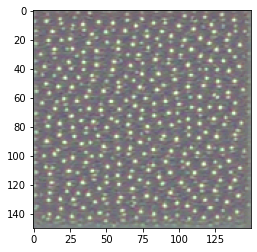

In [9]:
import matplotlib.pyplot as plt

img = input_img_data[0]

plt.imshow(deprocess_image(img))

The above filter seems to be looking for polkadot patterns, how interesting!

# We can create a simple function for this entire process

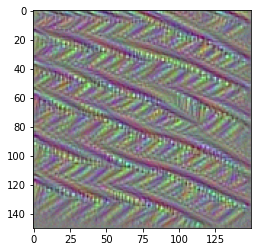

In [10]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

# Select any filter you wish to visualize
plt.imshow(generate_pattern('block3_conv3', 22))

The above pattern is well defined, but a bit hard to interpret what it actually is looking for. Perhaps it's a snake like pattern.

It's now important to realize a CNN like VGG16 has almost 1500 individual CONV filters, many different combinations of filter patterns need to be activated in order to indicate a specific class has been identified.

# Implementing Grad-CAM

In [0]:
# import our necessary libaries

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### Let's use the Xception model to demonstate Grad-CAM

In [0]:
# We load our xception model 
model_builder = keras.applications.xception.Xception

# define the input size 
img_size = (299, 299)

# extract the pre_process input and the decode predict functions
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

# Store the names of the last convolution layer and the classifier layer names
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]

### Point to our image

In [13]:
# The local path to our target image
img_path = keras.utils.get_file(
    "african_elephant.jpg", " https://i.imgur.com/Bvro0YD.png"
)

display(Image(img_path))

Output hidden; open in https://colab.research.google.com to view.

### Helper function that loads our image in the right format

In [0]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

## Our Grad-CAM Heatmap function

In [0]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

### Displaying the Heatmap

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.8871445)]


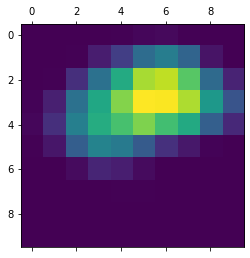

In [16]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

## Overlaying the heatmap onto the original input image

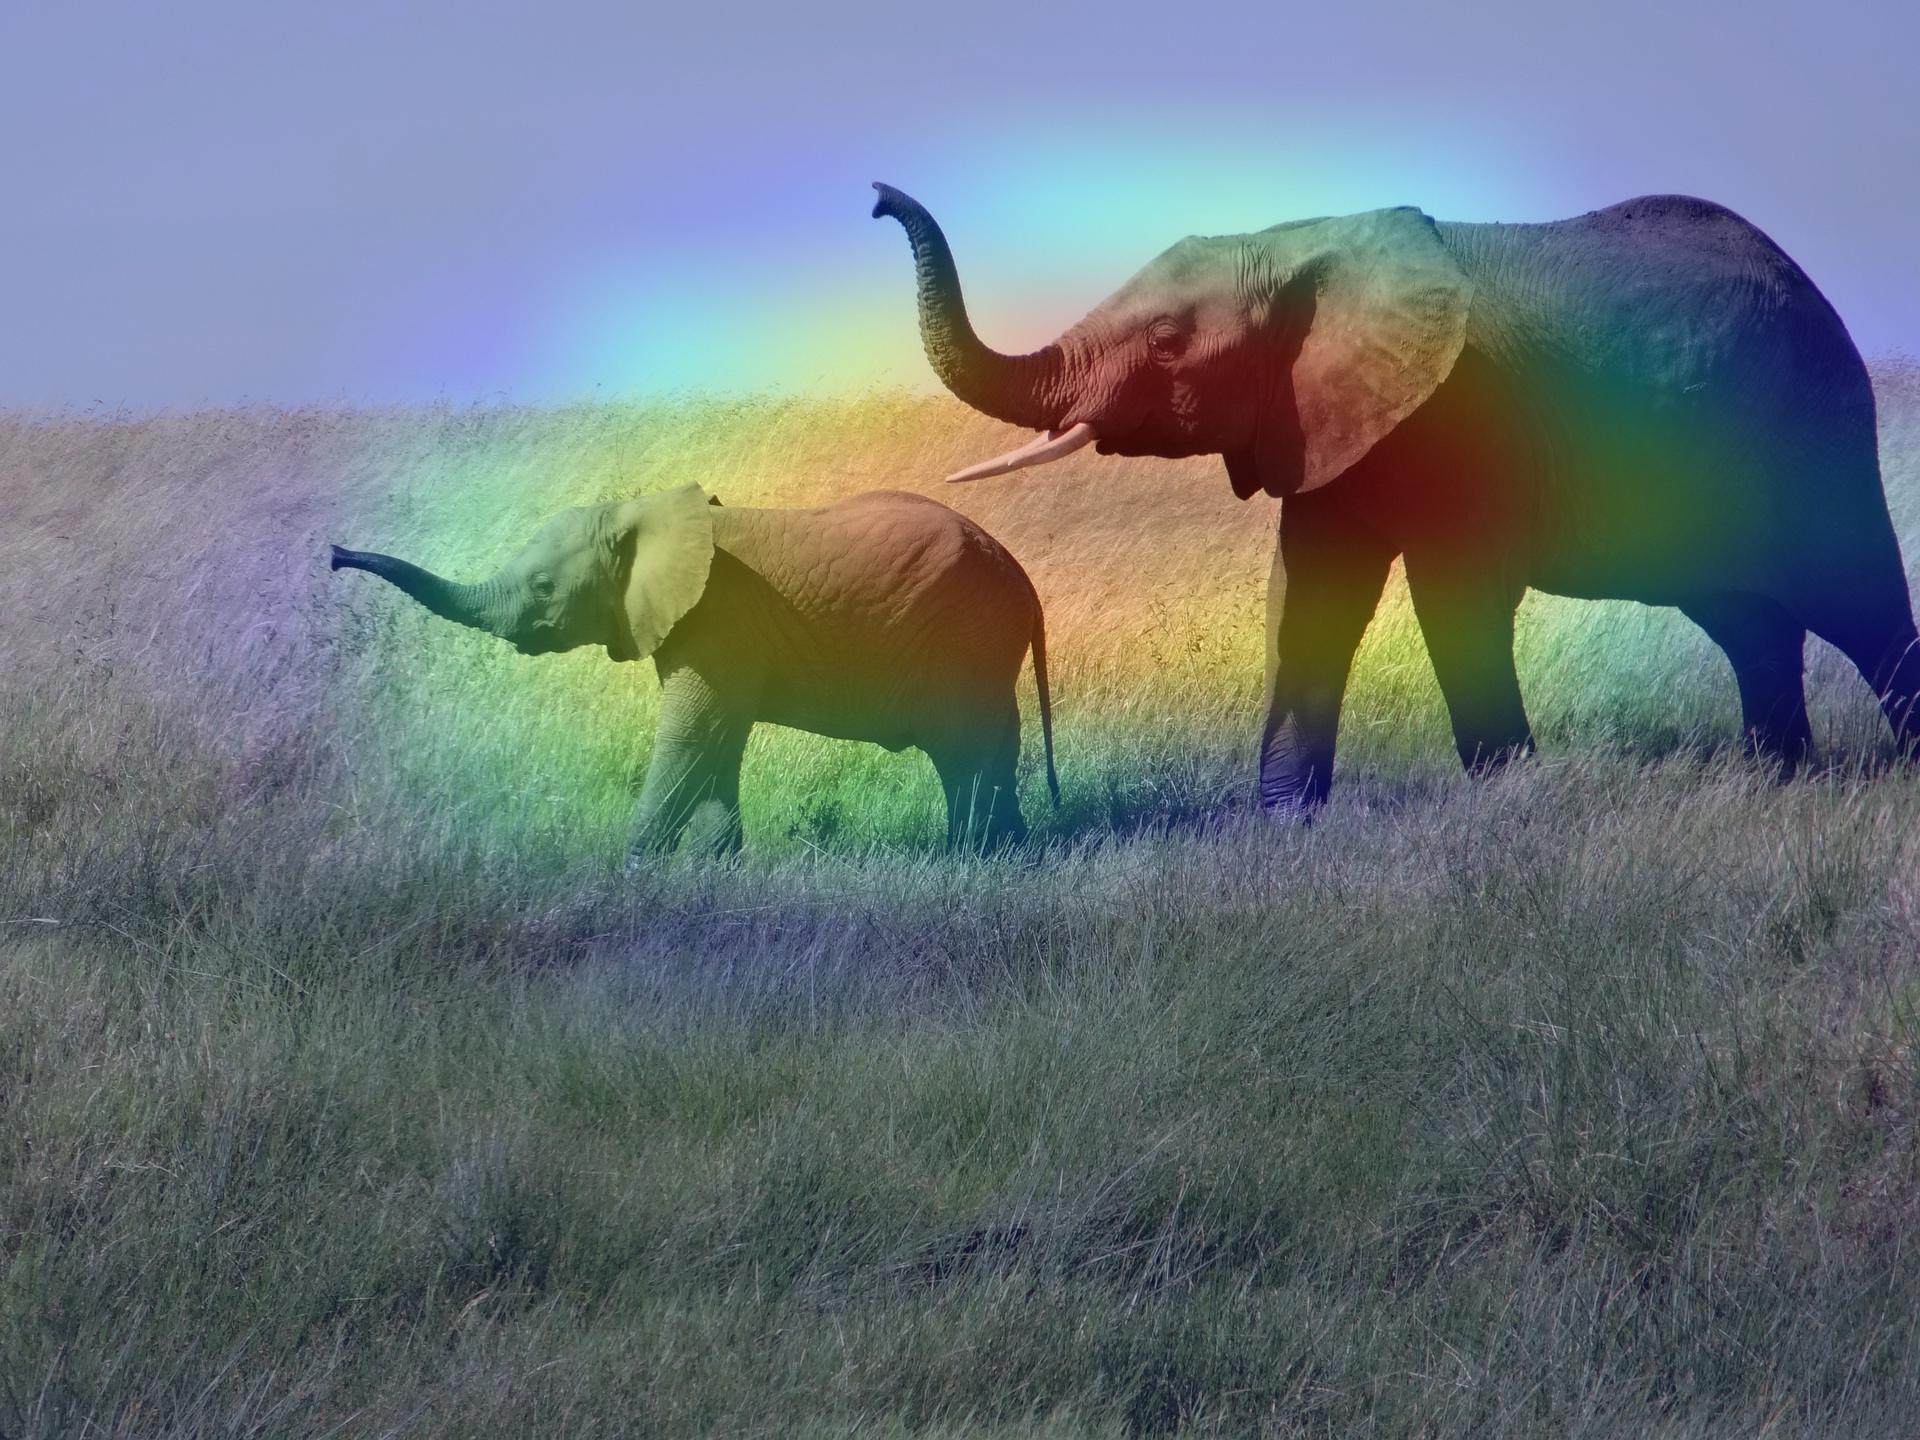

In [17]:
# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

# Finding an input that maximizes a specific class

In [18]:
# You might need to downgrade scipy to for compatability with keras-vis
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 102kB/s 
ERROR: umap-learn 0.4.3 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


# Finding an input that maximizes a specific classn VGGNet

## Dense Layer Visualizations
To visualize activation over final dense layer outputs, we need to switch the softmax activation out for linear since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide utils.apply_modifications to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear' and compare what happens if we dont do this at the end.# 

In [19]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

553467904/553467096 [==============================] - 19s 0us/step


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Visualizing a specific Class

Let's attempt to visualize a specific class. We'll try to see what our CNN thinks a Bald Eagle (class 22) looks like.

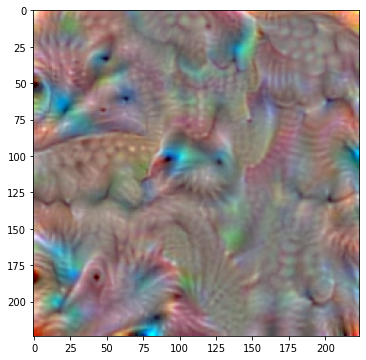

In [20]:
from vis.visualization import visualize_activation

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# 22 is the imagenet category for 'bald eagle'
img = visualize_activation(model, layer_idx, filter_indices=22)
plt.imshow(img)

#### We can just about see things that resemble a bald eagle in this picture, let us clean it up a bit more by increasing the number of iterations

Iteration: 1, named_losses: <zip object at 0x7fc4a6732888>, overall loss: 6457.5107421875
Iteration: 2, named_losses: <zip object at 0x7fc4a67329c8>, overall loss: 3179.599365234375
Iteration: 3, named_losses: <zip object at 0x7fc4a6732a88>, overall loss: 1654.526123046875
Iteration: 4, named_losses: <zip object at 0x7fc4a6732b88>, overall loss: 841.9104614257812
Iteration: 5, named_losses: <zip object at 0x7fc4a67328c8>, overall loss: 407.7428283691406
Iteration: 6, named_losses: <zip object at 0x7fc4a6732cc8>, overall loss: 209.2202606201172
Iteration: 7, named_losses: <zip object at 0x7fc4a6732dc8>, overall loss: 150.20721435546875
Iteration: 8, named_losses: <zip object at 0x7fc4a6732ec8>, overall loss: 104.29800415039062
Iteration: 9, named_losses: <zip object at 0x7fc4a6732b88>, overall loss: 76.49576568603516
Iteration: 10, named_losses: <zip object at 0x7fc4a67a0048>, overall loss: 57.293800354003906
Iteration: 11, named_losses: <zip object at 0x7fc4a67a0108>, overall loss: 42.

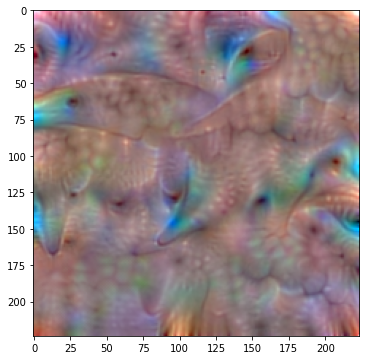

In [21]:
# 22 is the imagenet category for 'bald eagle'
img = visualize_activation(model, layer_idx, filter_indices=22, max_iter=500, verbose=True)
plt.imshow(img)

### It's cleaner, now let's use the input modifier jitter to generate a more crisp image

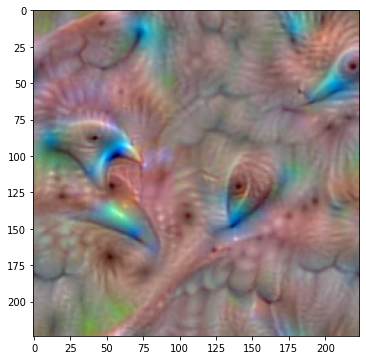

In [22]:
from vis.input_modifiers import Jitter

# 22 is the imagenet category for 'bald eagle'
# We set Jitter 16 pixels along all dimensions to during the optimization process.
img = visualize_activation(model, layer_idx, filter_indices=22, max_iter=500, input_modifiers=[Jitter(16)])
plt.imshow(img)

### Try this for different classes in the imagenet pretrained models to experiment!

In [0]:
pip freeze > requirements.txt